In [1]:
from requests import get
from requests import codes
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
def simple_get(url):
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None
            
    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
    
def is_good_response(resp):
    return resp.status_code == codes.ok


def log_error(e):
    print(e)

In [3]:
#import data into a dataframe
def importData(player):
    playerUrl = player_dict[player]
    raw_html = simple_get(playerUrl)
    html = BeautifulSoup(raw_html, 'html.parser')
    tagObjectList1 = html.find('tr',{'class': 'headlinks'})
    tagObjectList2 = html.find_all('tr',{'class': 'data1'})
    rawHeaders = tagObjectList1.getText().split('\n')
    headers = list(filter(lambda x: x != '', rawHeaders))
    collatedTable = []
    
    for i in range(len(tagObjectList2)):
        if i == 0:
            """
            Ignore (skip) overall statistics row
            """
            continue
        else:
            rawTableRow = tagObjectList2[i].getText().split(' ' and '\n')
            tableRow = list(filter(lambda x: x != '', rawTableRow))
            del tableRow[-1]
            collatedTable.append(tableRow)

    playerStats = pd.DataFrame(collatedTable,columns=headers)
    
    return playerStats

In [4]:
#clean data
def cleanData(playerStats):
    notOutPattern = re.compile('\*')
    DNBPattern = re.compile('DNB|sub')

    for index, row in  playerStats.iterrows():
        notOutMatch = notOutPattern.search(row['Runs'])
        if notOutMatch:
            row['Runs'] = row['Runs'][:len(row['Runs'])-1]
        else:
            row['Runs'] = row['Runs']

    for index, row in  playerStats.iterrows():       
        DNBMatch = DNBPattern.search(row['Runs'])
        if DNBMatch:
            playerStats.drop(index, axis=0, inplace=True)

    for index, row in  playerStats.iterrows():
        row['Opposition'] = row['Opposition'][2:]
    
    playerStats['Runs'] = pd.to_numeric(playerStats['Runs'])
    playerStats['BF'] = pd.to_numeric(playerStats['BF'])
    playerStats['4s'] = pd.to_numeric(playerStats['4s'])
    playerStats['6s'] = pd.to_numeric(playerStats['6s'])
    playerStats['SR'] = pd.to_numeric(playerStats['SR'])
    playerStats['Pos'] = pd.to_numeric(playerStats['Pos'])
    playerStats['Inns'] = pd.to_numeric(playerStats['Inns'])
    playerStats['Start Date'] = pd.to_datetime(playerStats['Start Date'])
    
    return playerStats    

In [11]:
def labelPlot(labels, rects, ax):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label,
                ha='center', va='bottom')
    
def PlotKeyStats(player, playerStats, res, colour):
    plt.rcParams.update({'font.size': 6})
    plotDataTL = playerStats.groupby('Pos')['Runs'].mean()
    plotDataTR = playerStats.groupby('Inns')['Runs'].mean()
    plotDataBL = playerStats.groupby('Opposition')['Runs'].mean()
    plotDataBR = pd.Series(playerStats['Runs'].values, index=playerStats['Start Date'])
    plotDataBR = plotDataBR.resample('A').mean()
    fig = plt.figure(dpi=res)

    # Top left plot
    axTL = fig.add_subplot(2,2,1)
    axTL.bar(plotDataTL.index, plotDataTL, color=colour)
    axTL.set_xlabel('Batting position')
    axTL.set_ylabel('Average')
    # optionally add value to top of bars
    #labelPlot(round(plotDataTL,1), axTL.patches, axTL)
    
    # Top right plot
    axTR = fig.add_subplot(2,2,2)
    axTR.bar(plotDataTR.index, plotDataTR, color=colour)
    axTR.set_xlabel('Innings')
    axTR.set_xticks([1, 2, 3, 4])
    axTR.set_ylabel('Average')
    #labelPlot(round(plotDataTR,1), axTR.patches, axTR)
    
    # Bottom left plot
    axBL = fig.add_subplot(2,2,3)
    axBL.bar(plotDataBL.index, plotDataBL, color=colour)
    axBL.set_xlabel('Country')
    plt.xticks(rotation=-70)
    axBL.set_ylabel('Average')
    #labelPlot(round(plotDataBL,1), axBL.patches, axBL)
    
    # Bottom right plot
    axBR = fig.add_subplot(2,2,4)
    axBR.bar(plotDataBR.keys().year, plotDataBR.get_values(), color=colour)
    axBR.set_xlabel('Year')
    axBR.set_xticks(plotDataBR.keys().year)
    plt.xticks(rotation=-60)
    axBR.set_ylabel('Average')
    #labelPlot(round(plotDataBR,1), axBR.patches, axBR)
    
    fig.suptitle(player, fontsize=8)
    fig.subplots_adjust(hspace=0.4)
    plt.savefig(player, bbox_inches='tight')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


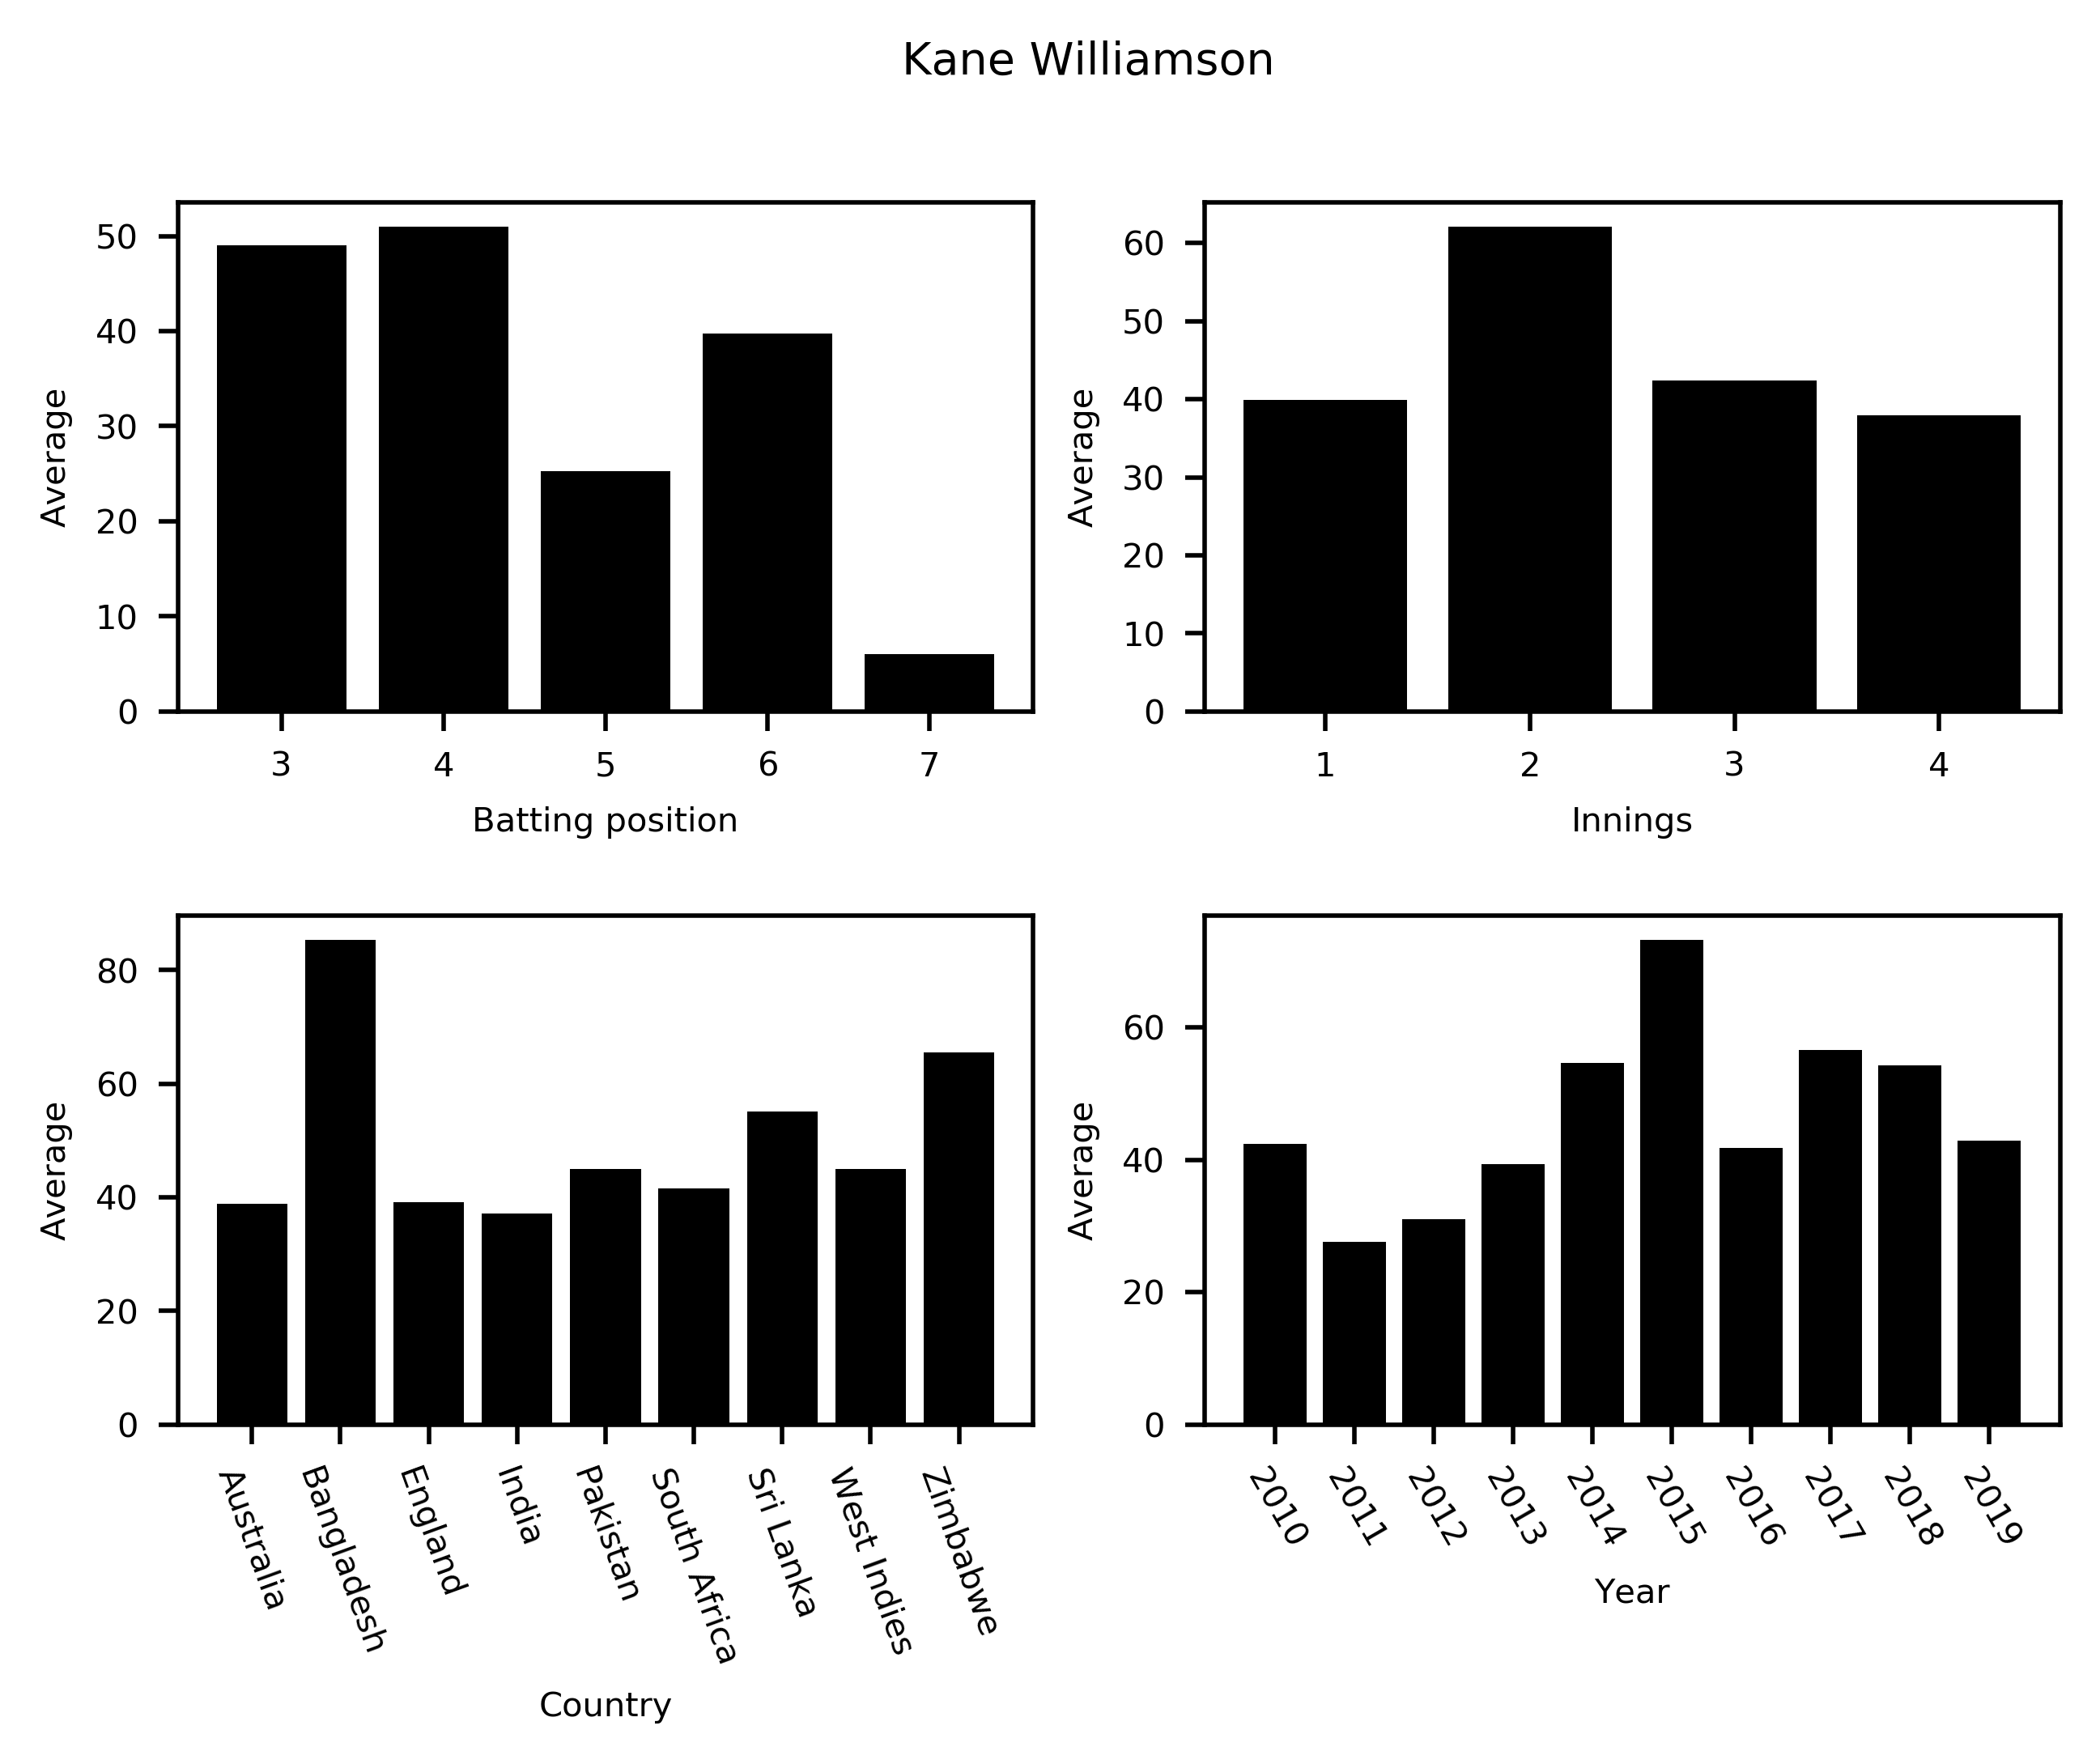

In [14]:
player_dict = {'Joe Root': 'http://stats.espncricinfo.com/ci/engine/player/303669.html?class=1;template=results;type=batting;view=innings',
               'Steve Smith': 'http://stats.espncricinfo.com/ci/engine/player/267192.html?class=1;template=results;type=batting;view=innings',
               'Virat Kohli' : 'http://stats.espncricinfo.com/ci/engine/player/253802.html?class=1;template=results;type=batting;view=innings',
               'Kane Williamson' : 'http://stats.espncricinfo.com/ci/engine/player/277906.html?class=1;template=results;type=batting;view=innings',
               'Kevin Pietersen' : 'http://stats.espncricinfo.com/ci/engine/player/19296.html?class=1;template=results;type=batting;view=innings',
               'Ricky Ponting' : 'http://stats.espncricinfo.com/ci/engine/player/7133.html?class=1;template=results;type=batting;view=innings',
               'Ben Stokes' : 'http://stats.espncricinfo.com/ci/engine/player/311158.html?class=1;template=results;type=batting;view=innings',
               'Jos Buttler' : 'http://stats.espncricinfo.com/ci/engine/player/308967.html?class=1;template=results;type=batting;view=innings',
               'Jonny Bairstow' : 'http://stats.espncricinfo.com/ci/engine/player/297433.html?class=1;template=results;type=batting;view=innings',
               'Moeen Ali' : 'http://stats.espncricinfo.com/ci/engine/player/8917.html?class=1;template=results;type=batting;view=innings'
              }

player = 'Kane Williamson'
rawPlayerStats = importData(player)
cleanedPlayerStats = cleanData(rawPlayerStats)
PlotKeyStats(player, cleanedPlayerStats, 500, 'k')